# 2. Responses to Stimuli and Deriving Metrics

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks:
1. *[Getting Started and Overview](1_GettingStarted.ipynb)*
2. **[Calculating Response to Stimulus and Metrics](2_Basics_StimRespMetrics.ipynb)**
3. *[Canonical Models](3_Basics_CanonModels.ipynb)*
4. *[Comparing Networks](4_UseCase_CompareNets.ipynb)*
5. *[Network Distance](5_UseCase_NetDist.ipynb)*
6. *[Weighted Networks](6_Basics_WeightedNets.ipynb)* 

---------------------

### Outline and functions used in this notebook
* Overview of basic concepts.
    * Pair-wise, node-wise and network level responses.
    * Network metrics from the responses.
    * Running simulations of the canonical models.
* `GlobalResponse`: evaluation of whole network effect resulting from stimulation
* `NodeResponses`: evaluation of broadcasting and receiving properties of nodes
* `Time2Peak` (TTP) and time-to-saturation that are proxy for distances in the graph

---------------------

#### Before begining, import the libraries we will need

In [2]:
# Python standard library imports
from timeit import default_timer as timer

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg

# Import SiReNetA
import sireneta as sna


In [24]:
# Define some plotting options to control visualization
%matplotlib inline
# Define the default scale for the plots
plt.rcParams['figure.dpi'] = 72

## Q: Can we make these cleaner? Direct import of cols from a file? 
# Add local function to load the new cmap.

# Define the colors for the plots later
#cols = ['deepskyblue', '#1f77b4', 'red', '#d62728']
cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
        '#e377c2', '#7f7f7f', '#bcbd22', '#17becf' ]

# Define a new "BwR", "Blues" and "Reds" colormaps
from matplotlib.colors import ListedColormap
newcmap = genfromtxt('../Data/Matplotlib_colormap_div.csv', delimiter=',')
newbwr = ListedColormap(newcmap)
newReds = ListedColormap(newcmap[128:, :])
newBlues = ListedColormap(newcmap[:128, :])


## 2.1. Basic concepts: understanding response curves

<!---
The aim of *Response Network Analysis (SRNA)* is to characterise the properties of complex networks from a dynamical perspective, alternatively to the combinatorial or probabilistic approach of classical graph theory. Under *SRNA* the observed network properties depend both on the structural connectivity (adjacency matrix *A*) but also on the rules governing how agents, particles or signals propagate along the network. Accordingly, the same connectivity may reveal different properties under different propagation paradigms.
--->

The core idea behind *SRNA* is to reveal the properties of networks by probing them via localised perturbations. A stimulus of unit amplitude applied at node *j* at time *t = 0* elicits responses $\mathcal{R}_{ij}(t)$ at all other nodes *i* over time. The pair-wise response, from *j* to *i*, is the result of the stimulus propagating over all possible routes, of all lengths, at different times. Hence, in *SRNA* the spatio-temporal response matrices $\mathcal{R}_{ij}(t)$ contain all the necessary information to characterise the network (jointly with its dynamics). 

<!---
>Graph analysis : Connectivity matrix *A*   ––>   probabilistic metrics.

>SRNA :  Connectivity matrix *A* + canonical propagation model  ––>  $\mathcal{R}_{ij}(t)$  ––>  spatio-temporal metrics.
REPLACE THIS BY A FIGURE !!
--->

Consider the small network below. We apply a unit stimulus at the first *j = 1* initially at time *t = 0* and observe the responses elicited on the other nodes, as the activity propagates along the chain.

<img src="img/PathDigraph1.jpg"  width="400" alt="Path Digraph, stim j=1" />

We will also assume the activity propagates following the *leaky-cascade* canonical propagation model:

$$\dot{\mathbf{x}}(t) = - \frac{1}{\tau} \mathbf{x}(t) \,+\, A \, \mathbf{x}(t) $$

where $\mathbf{x}(t)$ is are the *N* signals and $\tau$ is a leakage time-constant controlling for the dissipation rate. See [xxxxx](#) for the details of the model.


To compute the response matrices of the matrix we will: 
* Load the adjacency matrix from a file (`net1`),
* Set the simulation parameters:
    * Duration (`tfinal`).
    * Simulation time step (`dt`).
    * Set the leakage time-constant (`tau`).
* Define the stimulus amplitudes (`stimvec`). 

To apply a stimulus only to the first node, `stimvec` is defined as an empty 1D array of length *N*, and only the first entry is set to 1.0.


In [4]:
#  Load the directed path graph from a file
net1 = np.loadtxt('../Data/Testnet_PathDigraph_N6.txt', dtype=int)
N = len(net1)

In [35]:
# Define the simulation parameters
# Set the temporal resolution
tfinal = 12
dt = 0.01
tpoints1 = np.arange(0.0, tfinal+dt, dt)
nsteps1 = len(tpoints1)

# Set the leakage time-constants τ
tau = 1.0

# Define the stimulation amplitude to every node
# In this example, only the first node is stimulated
stimvec = np.zeros(N)
stimvec[0] = 1.0


### Pair-wise responses

Now, we compute and visualize the pair-wise responses $\mathcal{R}_{ij}(t)$ over time. The result `R1` is a 3D array of shape (nsteps, N,N), with the temporal dimension along the first axis. `nsteps` is the number of time samples of the simulation.

> _**ACHTUNG !!**_ *SiReNetA* follows the dynamical systems convention for which $A_{ij} = 1$ means a link from *j* to *i*. This is contrary to the convention in graph theory that would consider $A_{ij} = 1$ for a link from *i* to *j*. Therefore, the transpose of the adjacency matrix `net1.T` is passed to the function calculating the response matrices `sna.Resp_LeakyCascade()`.

In [40]:
# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
#R1 = sna.Resp_ContCascade(net1.T, S0=stimvec, tmax=tfinal, timestep=dt)
R1 = sna.Resp_LeakyCascade(net1.T, S0=stimvec, tmax=tfinal, timestep=dt)
time2 = timer()
print( time2 - time1, 'seconds' )

print( "Shape of R1:", R1.shape)

0.516854511000929 seconds
Shape of R1: (1201, 6, 6)


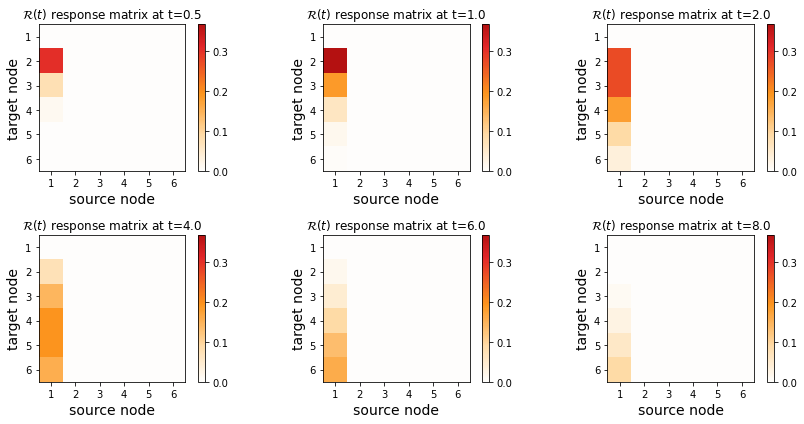

In [41]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp = R1.max()

tidxlist = [50,100,200,400,600,800]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints1[tidx]
    plt.subplot(2,3,i+1)
    plt.title('$\mathcal{R}(t)$ response matrix at t=%1.1f' %t)
    plt.imshow(R1[tidx], cmap=newReds)
    plt.clim(0,maxresp)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel('source node')
    plt.ylabel('target node')

plt.tight_layout()

Visualize the response curves over time. Plot the responses of nodes *i = 2, ..., 6* to the stimulus at *j = 1*.

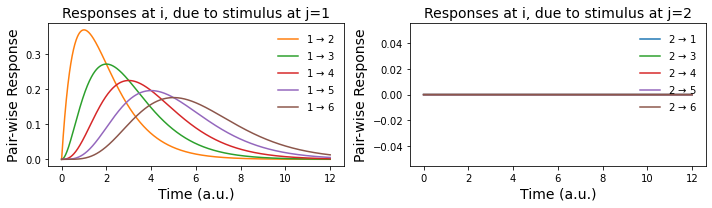

In [25]:
# Plot the responses to stimulus applied at j = 1.
plt.figure(figsize=(10,3))

# Plot the responses from 1 to others
plt.subplot(1,2,1)
plt.title( 'Responses at i, due to stimulus at j=1', fontsize=14)
for i in range(1,N):
    plt.plot(tpoints1, R1[:,i,0], color=cols[i], label='1 $\\to$ %d' %(i+1))
plt.xlabel('Time (a.u.)', fontsize=14)
plt.ylabel('Pair-wise Response', fontsize=14)
plt.legend(frameon=False)

# Plot the responses from 2 to others
plt.subplot(1,2,2)
plt.title( 'Responses at i, due to stimulus at j=2', fontsize=14)
for i in [0,2,3,4,5]:
    plt.plot(tpoints1, R1[:,i,1], color=cols[i], label='2 $\\to$ %d' %(i+1))
plt.xlabel('Time (a.u.)', fontsize=14)
plt.ylabel('Pair-wise Response', fontsize=14)
plt.legend(frameon=False)


plt.tight_layout()

CONTINUE HERE !!


LESSON 1: Responses are conditional. No input at *j*, then no responses detected at other nodes.

LESSON 2: Responses are pair-wise **BUT (!!)** through the network !!

<br>

### Stimuli are independent, so are their responses

Perturbations are independent. Doesn't matter whether they are applied simultaneously or one after another !!!

NEXT: Give two inputs j=1 and j=3. Visualize again the response matrices.


<img src="img/PathDigraph3.jpg"  width="400" alt="Path Digraph, stim j=1 and j=4" />

In [43]:
# Define the stimulation amplitude to every node
# In this example, only the first node is stimulated
stimvec = np.zeros(N)
stimvec[0] = 1.0
stimvec[3] = 1.0

# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
#R2 = sna.Resp_ContCascade(net1.T, S0=stimvec, tmax=tfinal, timestep=dt)
R2 = sna.Resp_LeakyCascade(net1.T, S0=stimvec, tmax=tfinal, timestep=dt)
time2 = timer()
print( time2 - time1, 'seconds' )

print( "Shape of R1:", R2.shape)

0.5141131689997565 seconds
Shape of R1: (1201, 6, 6)


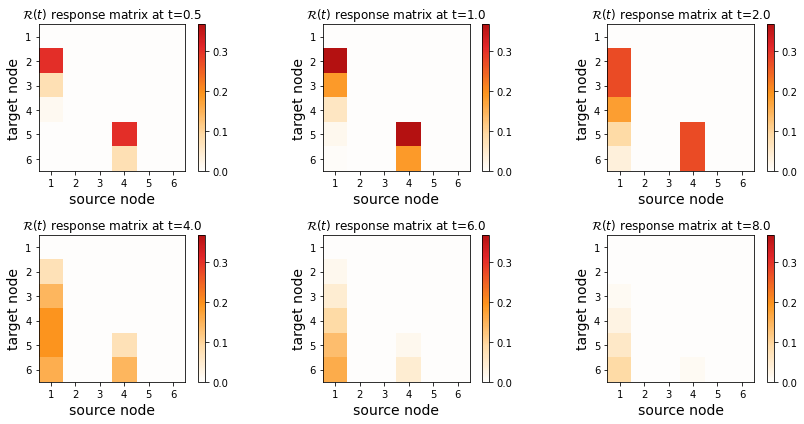

In [44]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp = R2.max()

tidxlist = [50,100,200,400,600,800]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints1[tidx]
    plt.subplot(2,3,i+1)
    plt.title('$\mathcal{R}(t)$ response matrix at t=%1.1f' %t)
    plt.imshow(R2[tidx], cmap=newReds)
    plt.clim(0,maxresp)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel('source node')
    plt.ylabel('target node')

plt.tight_layout()

### Changing the canonical propagation model

Same example with ... the discrete cascade (?) and the random walk.

### Input and output responses to quantify the receiving and broadcasting properties of nodes

For this, move to the directed TestNet_N8, and add stimulus in all nodes. Show 

- response matrices,
- in / out responses,
- Global network response.

## Input and output responses to quantify the receiving and broadcasting properties of nodes

As seen, the effect of the stimulus initially applied at the first node affects other nodes down the chain at different times. We visualize this more explicitely, computing the input and output responses of every node over time.

In [ ]:
# Calculate the in-/out- full-flow for every node
# infullflow and outfullflow are two arrays of shape (N,nsteps)
inresp1, outresp1 = sna.NodeResponses(resp1, selfloops=True)

# Plot a figure wit the input and output responses of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Response for every node', fontsize=12)
for i in range(N):
    plt.plot(tpoints1, inresp1[:,i], label='i = %d' %(i+1))
#plt.ylim(-0.005,0.1)
plt.ylabel('in-responses', fontsize=14);
plt.legend(frameon=False, loc='center left')

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints1, outresp1[:,i], label='i = %d' %(i+1))
plt.ylabel('out-responses', fontsize=14);
plt.xlabel('Time (a.u.)', fontsize=14);

## Area under the curve as a measure of effect integrated over time

xxx TO CLEAN

In [ ]:
# Visualise the total link-wise responses
pw_resp1 = sna.AreaUnderCurve(resp1, timestep=1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Adjacency matrix')
plt.imshow(dirnet, cmap='gray_r')
plt.colorbar()
plt.xticks(np.arange(N), np.arange(N)+1)
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('source node')
plt.ylabel('target node')
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('Total pair-wise responses (influence)')
plt.imshow(pw_resp1, cmap='gray_r', vmin=0)
plt.colorbar()
plt.xticks(np.arange(N), np.arange(N)+1)
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('source node')
plt.ylabel('target node')
plt.tight_layout()

plt.tight_layout()

&nbsp;

--------
## XXX TO CLEAN 3. First steps into Stimulus-Response Network Analysis (SRNA)


The core idea behind *SRNA* is to reveal the properties of networks by probing how the nodes of a network respond localised perturbations. That is, to apply a stimulus of unit amplitude to one node and observe how the others respond. The manner in which the stimulus propagates throughout the network depends on the dynamical propagation dynamical model selected. Network metrics are then extracted out of the pair-wise, node-wise or global responses.

For illustration, we will load the small graph (binary and undirected) depicted below and  visualise the different types of responses.

![Sample Graph, n=8 nodes](#)



## Changing the propagation model

Now we switch to the continuous leaky cascade, a different model in continuous time

In [ ]:

# Find the spectral radius and the largest time constant 
evs = np.linalg.eigvals(dirnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = np.real(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:\t%2.5f' %evmax )
print( 'Largest possible tau:\t%2.5f' %maxtau )

For a given network represented by $A$, the tendency of the network dynamics to diverge is represented by the largest eigenvalue (spectral radious) $\lambda_{max}$ of $A$. To assure the convergence of the system the leakage along each node needs to counterbalance this tendency. For that, the condicion $\tau < \tau_{max}$ with $\tau_{max} = 1 \,/\, \lambda_{max}$ needs to be fulfilled. 
In this particular case, all the eigenvalues of the directed path graph are zero, thus, $\tau_{max} = \infty$ and the system converges for any value of $\tau$. But this will not be the case in general.

We now define an _**external perturbation**_, which is encoded in the `stimvec` array, containing the amplitude on the initial stimuli at each node. In this case, we assume an stimulus of unit amplitude, only at the first node.

In [ ]:
# Set the matrix of noisy inputs
stimvec = np.zeros(N)
stimvec[0] = 1.0

# Set a leakage time-constant smaller than the largest possible value above
tau = 0.25

# Define the temporal resolution for the "simulation"
dt = 0.01
tpoints2 = np.arange(0.0, tfinal+dt, dt)
nsteps2 = len(tpoints2)

# Calculate the pair-wise responses for a time span between 0 and tmax
resp2 = sna.Resp_LeakyCascade(dirnet, S0=stimvec, tau=tau, tmax=tfinal, timestep=dt, case='full') 

In [ ]:
# Visualise the flow matrices at different times
tlist = [0, 100, 200, 400, 600, 800, 1000]
for tidx in tlist:
    plt.figure()
    plt.title('Time t = %2.2f' %(tidx*dt) )
    plt.imshow(resp2[tidx])
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel('source node')
    plt.ylabel('target node')
    plt.tight_layout()


As seen, the effect of the stimulus initially applied at the first node affects other nodes down the chain at different times. We visualize this more explicitely, computing the input and output responses of every node over time.

In [ ]:
# Calculate the in-/out- full-flow for every node
# infullflow and outfullflow are two arrays of shape (N,nsteps)
inresp2, outresp2 = sna.NodeResponses(resp2, selfloops=True)

# Plot a figure wit the input and output responses of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Full-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints2, inresp2[:,i], label='i = %d' %(i+1))
#plt.ylim(-0.005,0.1)
plt.ylabel('in-responses', fontsize=14);
plt.legend(frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints2, outresp2[:,i], label='i = %d' %(i+1))
plt.ylabel('out-responses', fontsize=14);
plt.xlabel('Time (a.u.)', fontsize=14);

In [ ]:
# Visualise the total link-wise responses
pw_resp2 = sna.AreaUnderCurve(resp2, timestep=1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Adjacency matrix')
plt.imshow(dirnet, cmap='gray_r')
plt.colorbar()
plt.xticks(np.arange(N), np.arange(N)+1)
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('source node')
plt.ylabel('target node')

plt.subplot(1,2,2)
plt.title('Total pair-wise responses (influence)')
plt.imshow(pw_resp2, cmap='gray_r', vmin=0)
plt.colorbar()
plt.xticks(np.arange(N), np.arange(N)+1)
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('source node')
plt.ylabel('target node')

plt.tight_layout()

## Comparison of the global and node responses across the 2 propagation models

In [ ]:
# Calculate the global response
glb_resp1 = sna.GlobalResponse(resp1)
glb_resp2 = sna.GlobalResponse(resp2)


plt.figure()
plt.plot(tpoints1, glb_resp1, label='discrete cascade')
plt.plot(tpoints2, glb_resp2, label='leaky cascade')
plt.tight_layout()

plt.figure()
plt.title('discrete cascade')
plt.imshow(inresp1.T)
plt.colorbar()
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('time')
plt.ylabel('target node')
plt.tight_layout()

plt.figure('leaky cascade')
plt.imshow(inresp2.T, aspect=100)
plt.colorbar()
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('time')
plt.ylabel('target node')
plt.tight_layout()

Despite very different global response, the two responses exhibit a similar structure for late times, as shown below. This suggests that they capture similar information from the underlying network (and the stimulation).

In [ ]:
# get corresponding times
t1 = 1
t2 = int(t1/dt)

plt.figure()
plt.scatter(resp1[t1], resp2[t2])
plt.xlabel('discrete cascade')
plt.ylabel('leaky cascade')
plt.title('time %2.1f' % t1)
plt.tight_layout()

t1 = 5
t2 = int(t1/dt)

plt.figure()
plt.scatter(resp1[t1], resp2[t2])
plt.xlabel('discrete cascade')
plt.ylabel('leaky cascade')
plt.title('time %2.1f' % t1)
plt.tight_layout()

t1 = 9
t2 = int(t1/dt)

plt.figure()
plt.scatter(resp1[t1], resp2[t2])
plt.xlabel('discrete cascade')
plt.ylabel('leaky cascade')
plt.title('time %2.1f' % t1)
plt.tight_layout()


## Time to peak

In [ ]:
plt.figure()
plt.title('Full-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints2, inresp2[:,i], label='i = %d' %(i+1))
#plt.ylim(-0.005,0.1)
plt.ylabel('in-responses', fontsize=14);
plt.legend(frameon=False)

sna.Time2Peak(resp2, timestep=dt)